# Plot

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def shaded_plot(ls,k_size=9):
    means,stds = [],[]
    for i in range(k_size//2,len(ls)-k_size//2):
        slc = ls[i-k_size//2:i+k_size//2+1]
        means.append(np.mean(slc))
        stds.append(np.std(slc))
    means,stds = np.array(means),np.array(stds)
    plt.plot(means)
    plt.fill_between(range(len(means)), means-stds, means+stds, alpha=0.3)

In [ ]:
SHADED = False
df = pd.read_csv("logs/UnsupervisedModelNoLogLoss.csv")

loss = df["spec_loss"]
val_loss = df["val_spec_loss"]

plt.figure(figsize=(9,9))
idx = 800
if SHADED:
    shaded_plot(loss[:idx])
    shaded_plot(val_loss[:idx])
else:
    plt.plot(loss)
    plt.plot(val_loss)
fs = 15
plt.legend(("train","validation"), fontsize=fs)
plt.xlabel("Epochs", fontsize=fs)
plt.ylabel("Multi-Scale Spectral Loss", fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.grid("tight")
plt.show()


In [4]:
df

,epoch,spec_loss,val_spec_loss
0,0,1.556114,1.487504
1,1,2.050954,1.932534
2,2,1.548794,1.906400
3,3,1.629068,1.755056
4,4,1.688661,1.462203
5,5,1.227791,1.669452
6,6,1.890698,1.772196
7,7,1.638974,1.532228
8,8,1.788263,1.658444
9,9,1.834331,1.808154


# Supervised Reconstruction

In [1]:
from tqdm.notebook import tqdm
import tensorflow as tf
import numpy as np

from tensorflow.keras.optimizers import Adam

from encoders import *
from preprocessing import *
from models import *
from decoders import *
from losses import *
from dataloader import make_datasets, read_violin_set

In [2]:
RUN_NAME = "Supervised_DecoderUpsampling"
epoch = 747
SAMPLE_RATE = 16000
#TIME_STEPS = 1000
N_FFT = 1024
BATCH_SIZE = 32
MODEL_PATH = "{}/{}/model.ckpt".format(RUN_NAME,epoch)

train_set, validation_set, _ = read_violin_set()


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])
/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encount

In [3]:
decoder = DecoderWithoutLatent(timesteps=1000)

preprocessor = F0LoudnessPreprocessor(timesteps=250)
loss = SpectralLoss()

model = SupervisedAutoencoder(preprocessor=preprocessor,
                                decoder=decoder,
                                loss_fn=loss)

model.build(input_shape={k:v.shape for k,v in next(iter(train_set.batch(16))).items()})

adam = Adam(learning_rate=1e-3)
model.compile(adam)
model.load(MODEL_PATH)

In [8]:
pred_audios = []
truth_audios = []
for batch in train_set.batch(1):
    pred = model.predict(batch,batch_size=1)
    pred_audios.append(pred["audio_synth"])
    truth_audios.append(batch["audio"])

In [24]:
from dsp_utils.spectral_ops import compute_loudness, compute_f0
from tqdm.notebook import tqdm
ls,ls2 = [], []
compute_loudness_my = lambda x:compute_loudness(x,
                     sample_rate=16000,
                     frame_rate=250,
                     n_fft=2048,
                     range_db=120.0,
                     ref_db=20.7,
                     use_tf=False)

for p,t in tqdm(zip(pred_audios,truth_audios)):
    f0_p, _ = compute_f0(p[0], 16000, 250, viterbi=True)
    f0_t, _ = compute_f0(t[0], 16000, 250, viterbi=True)
    l_p = compute_loudness_my(p[0])
    l_t = compute_loudness_my(t[0])
    f0_p,f0_t = hz_to_midi(f0_p),hz_to_midi(f0_t)
    ls.append(np.mean(np.abs(f0_p-f0_t)))
    ls2.append(np.mean(np.abs(l_p-l_t)))
    print(np.mean(ls),np.mean(ls2))

/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.73101485 38.98903955554693


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.9031355 38.21516530508534


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.83103245 38.0040481992526


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8452935 38.198903881113715


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.7680114 38.3243260188641


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.769326 38.1335556428759


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8370042 38.0249322994485


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.80353725 38.38507318583869


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8285577 38.34465410673214


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.82112944 38.439911515727815


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.83333105 38.22587147934098


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8186743 38.317646698097235


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.80339396 38.28588492817548


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8454741 38.29124272288406


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8213855 38.45809744051654


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.86241126 38.595675722639825


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8660324 38.48985804100428


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8440485 38.59621875948713


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.84209734 38.65019225784557


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.82357323 38.6741812576099


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8247233 38.71068541202126


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8125269 38.63053006473343


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8326107 38.70521329777933


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.820601 38.65301188745095


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8514042 38.723308844714026


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8496459 38.73879578746271


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8477567 38.677242328835


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.83444864 38.72979693974569


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8252636 38.76406012849796


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8137209 38.83470233246036


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.83476335 38.76484987520712


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8271599 38.65101385993572


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.82232875 38.68832163198736


/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


0.8172684 38.717433942096534
0.8089592 38.796393269662296



/kuacc/users/hbalim15/.local/lib/python3.7/site-packages/librosa/core/convert.py:1354: RuntimeWarning: divide by zero encountered in log10
  - 0.5 * np.log10(f_sq + const[3])


# Calculate recons loss

In [1]:
from tqdm.notebook import tqdm
import tensorflow as tf
import numpy as np

from tensorflow.keras.optimizers import Adam

from encoders import *
from preprocessing import *
from models import *
from decoders import *
from losses import *
from dataloader import make_datasets, read_violin_set


RUN_NAME = "Unsupervised_DecoderUpsampling"
epoch = 17
SAMPLE_RATE = 16000
#TIME_STEPS = 1000
N_FFT = 1024
BATCH_SIZE = 32
MODEL_PATH = "{}/{}/model.ckpt".format(RUN_NAME,epoch)

train_set, validation_set, test_set = make_datasets(BATCH_SIZE,percent=10)

encoder_z = Encoder_z(timesteps=250)
encoder_f0 = Encoder_f(timesteps=250)

decoder = DecoderWithLatent()

preprocessor = MidiF0LoudnessPreprocessor(timesteps=250)
loss = SpectralLoss()

model = UnsupervisedAutoencoder(preprocessor=preprocessor,
                                encoder_f0=encoder_f0,
                                encoder_z=encoder_z,
                                decoder=decoder,
                                loss_fn=loss)

model.build(input_shape={k:v.shape for k,v in next(iter(test_set.take(1))).items()})

adam = Adam(learning_rate=1e-3)
model.compile(adam)
model.load(MODEL_PATH)

In [2]:
def calculate_recons_f0_error(model,dataset):
    preds,truth = [],[]
    for i,batch in tqdm(enumerate(dataset),total=dataset.my_len):
        if i == dataset.my_len:
            break
        truth.append(hz_to_midi(core.resample(batch["f0_hz"],250)).numpy()/F0_RANGE)
        pred = model.encode(batch)
        preds.append(pred["f0_midi_scaled"].numpy()[:,:,0])
    preds,truth = np.array(preds),np.array(truth)
    error = np.mean(np.abs(preds-truth))
    return error
calculate_recons_f0_error(model, test_set)

0.2957743

In [3]:
import matplotlib.pyplot as plt
import IPython.display as ipd
def print_plot_play(x, Fs, text=''):
    print('%s\n' % (text))
    print('Fs = %d, x.shape = %s, x.dtype = %s' % (Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs)) #,normalize=False

In [4]:
for batch in test_set.take(1):
    break

In [12]:
pred = model(batch)



Fs = 16000, x.shape = (64000,), x.dtype = float32


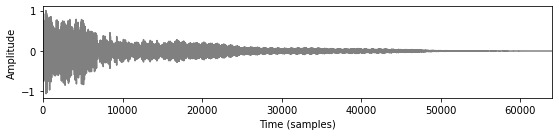

In [39]:
idx = 9
p = pred["audio_synth"][idx].numpy()
p = p/p.max()
print_plot_play(p,16000)



Fs = 16000, x.shape = (64000,), x.dtype = float32


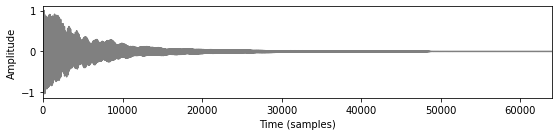

In [40]:
true = batch["audio"][idx].numpy()
true = true/true.max()
print_plot_play(true,16000)

In [38]:
from scipy.io.wavfile import write
write("p.wav",16000,p)
write("t.wav",16000,true)

